# Recreating @eleonoran's implementation which can be found [here](https://ibb.co/h1F0Lh1).

In [1]:
# Set report variables
team_name = 'Chicago'
min_season = '2000-01'
max_season = '2017-18'

In [2]:
import math
import numpy as np 
import pandas as pd
from PIL import Image

import matplotlib
from matplotlib.backends.backend_pgf import FigureCanvasPgf
matplotlib.backend_bases.register_backend('pdf', FigureCanvasPgf)

from matplotlib import rc
rc('text',usetex=True)
rc('text.latex', preamble=r'\usepackage{xcolor}')
rc('pgf', preamble=r'\usepackage{xcolor}', rcfonts=False)

import matplotlib.pyplot as plt
import seaborn as sns

pd.options.mode.chained_assignment = None # surpress is copy warning

In [3]:
df = pd.read_csv('../NHL Attendance.csv')
print(df.columns)
print(df.head())

Index(['SEASON', 'RANK', 'TEAM', 'HOME GAMES', ' HOME ATTENDANCE ',
       'ROAD GAMES', ' ROAD ATTENDANCE ', 'TOTAL GAMES', ' TOTAL ATTENDANCE '],
      dtype='object')
    SEASON  RANK          TEAM  HOME GAMES  HOME ATTENDANCE   ROAD GAMES  \
0  2017-18     1       Chicago          41          887,794           41   
1  2017-18     2      Montreal          41          873,283           41   
2  2017-18     3  Philadelphia          41          800,214           41   
3  2017-18     4       Detroit          41          800,115           41   
4  2017-18     5       Toronto          41          786,677           41   

   ROAD ATTENDANCE   TOTAL GAMES  TOTAL ATTENDANCE   
0          723,773            82         1,611,567   
1          733,736            82         1,607,019   
2          702,781            82         1,502,995   
3          717,295            82         1,517,410   
4          751,940            82         1,538,617   


In [4]:
def clean_numeric_column(df, column_name):
    series = df[column_name].str.strip()
    series = series.str.replace(',', '')
    series = pd.to_numeric(series)
    df[column_name] = series
    return df

df = clean_numeric_column(df, ' TOTAL ATTENDANCE ')
df = clean_numeric_column(df, ' HOME ATTENDANCE ')

In [5]:
def get_value_from_column(df, filter_column, filter_value, value_column):
    row = df.query(f'{filter_column} == @filter_value')
    return row.iloc[0][value_column]

In [6]:
# Header - Get totals for seasons
season_sums = df.groupby('SEASON').sum()
season_sums = season_sums.reset_index(level='SEASON')

min_season_attendance = get_value_from_column(season_sums, 'SEASON', min_season, ' HOME ATTENDANCE ')
max_season_attendance = get_value_from_column(season_sums, 'SEASON', max_season, ' HOME ATTENDANCE ')
print('starting attendance: ', min_season_attendance)
print('ending attendance: ', max_season_attendance)

starting attendance:  20399945
ending attendance:  22174263


In [7]:
# Header - Get totals for teams
team_sums = df.query('SEASON == @max_season').groupby('TEAM').sum()
team_sums = team_sums.reset_index(level='TEAM')

top_5_teams = team_sums.sort_values(by=' HOME ATTENDANCE ', ascending=False)[:5]
print(top_5_teams[['TEAM', ' HOME ATTENDANCE ']])

            TEAM   HOME ATTENDANCE 
6        Chicago             887794
15      Montreal             873283
21  Philadelphia             800214
10       Detroit             800115
26       Toronto             786677


In [8]:
# Graphs - Get selected team data
team_df = df.query('TEAM == @team_name')
team_min_season_attendance = get_value_from_column(team_df, 'SEASON', min_season, ' HOME ATTENDANCE ')
print('min season team attendance: ', team_min_season_attendance)

team_df['CHANGE FROM MIN SEASON'] = team_df.apply(lambda row: row[' HOME ATTENDANCE '] - team_min_season_attendance, axis = 1)
print(team_df.head()[['SEASON', ' HOME ATTENDANCE ', 'CHANGE FROM MIN SEASON']])

min season team attendance:  614875
      SEASON   HOME ATTENDANCE   CHANGE FROM MIN SEASON
0    2017-18             887794                  272919
31   2016-17             891827                  276952
61   2015-16             896240                  281365
91   2014-15             892532                  277657
121  2013-14             927545                  312670


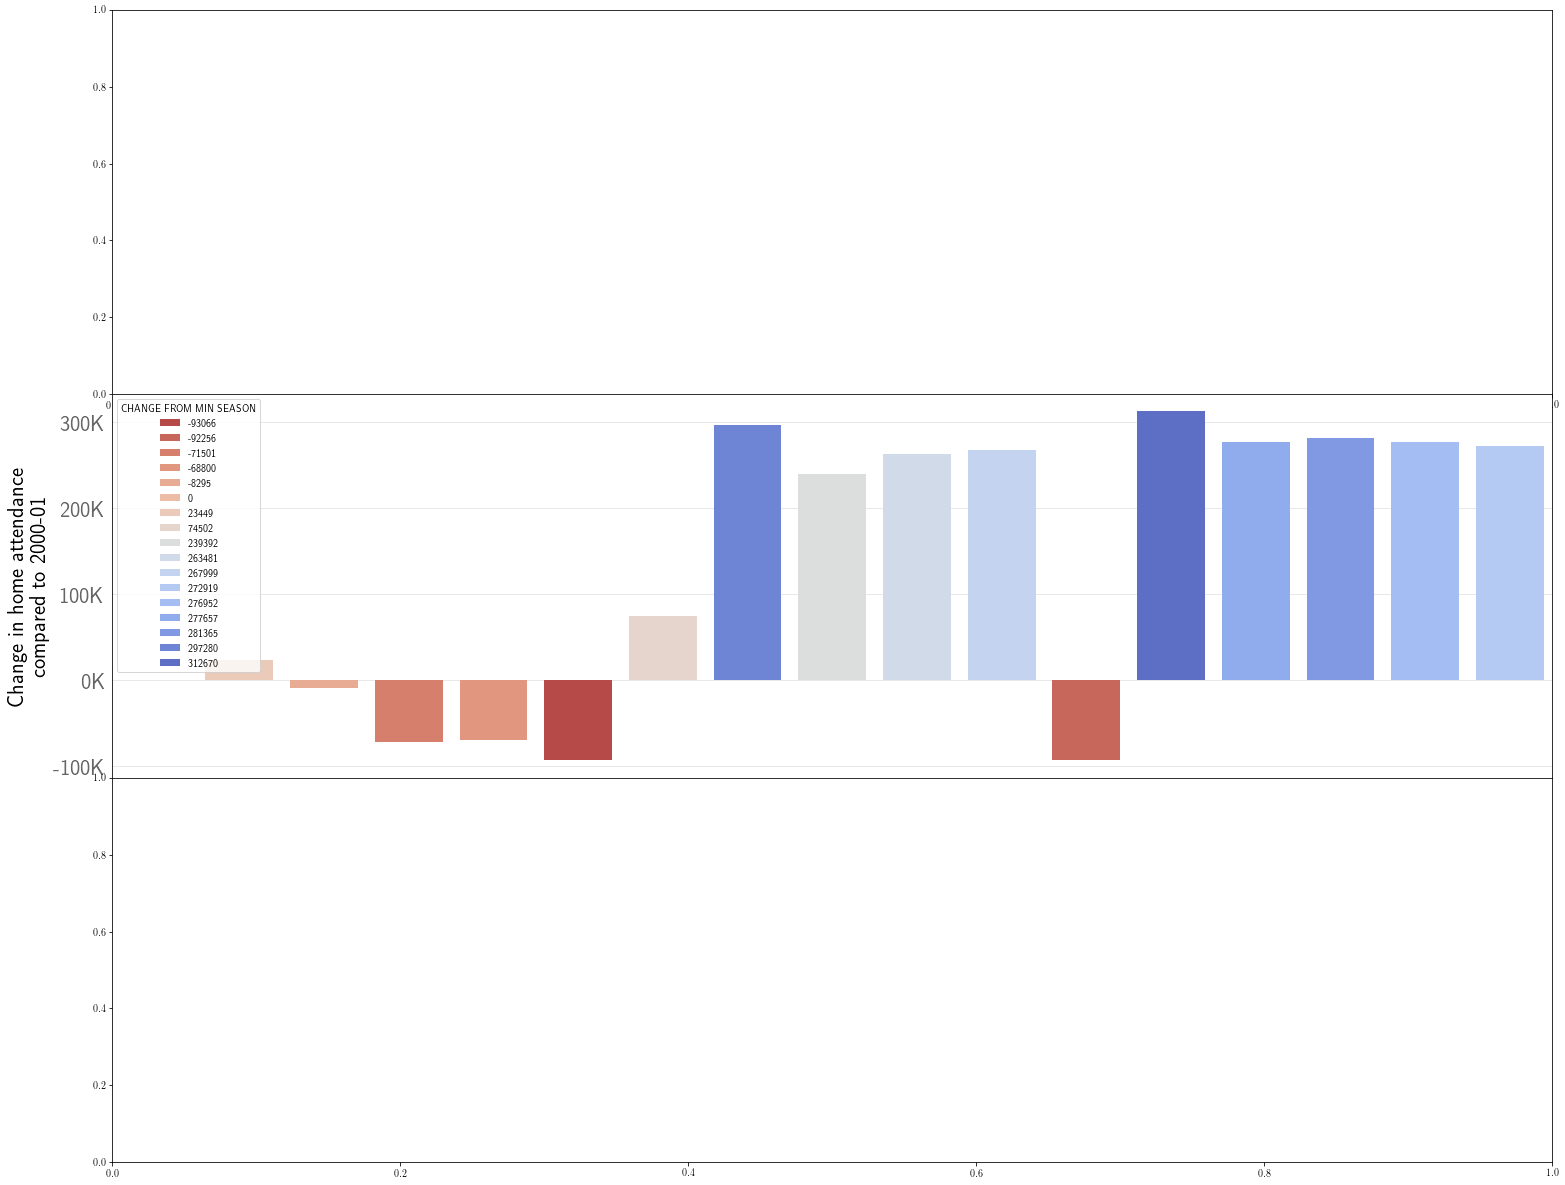

In [53]:
fig, (header_ax, bar_ax, line_ax) = plt.subplots(nrows=3, figsize=(20,16), gridspec_kw={"height_ratios":[0.3, 0.3, 0.3]})
fig.subplots_adjust(0,0,1,1,0,0)

# Drawing - Bar graph
def format_bar_y(y):
    y = str(y)
    if len(y) > 3:
        return y[:-3] + 'K' 
    
    return y + 'K'


def draw_bar_graph(team_df, min_season, bar_ax):
    hue = team_df['CHANGE FROM MIN SEASON']
    team_df = team_df.sort_values(by='SEASON', ascending=True)
    ax = sns.barplot(
        y='CHANGE FROM MIN SEASON', x='SEASON', data=team_df, ax=bar_ax, zorder=3,
        hue=hue, dodge=False, palette='coolwarm_r'
    )

    ax.yaxis.grid(color='lightgray', linewidth='0.5', zorder=0)
    ax.set_yticks(np.array([3, 2, 1, 0, -1], dtype=int)*100000)
    ax.tick_params(axis="y", labelsize=22, labelcolor='#666666', width=0)
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda y, p:format_bar_y(y)))
    ax.set_ylabel('Change in home attendance \ncompared to ' + min_season, fontsize=22)
    
draw_bar_graph(team_df, min_season, bar_ax)